In [1]:
# imports
import os
import numpy as np
import time
from tinygrad import Tensor
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

os.environ['GPU'] = '1' # set to tinygrad backend to GPU since METAL doesn't work on older intel macs

In [2]:
# import and clean pokemon name data

import csv

moves = []

with open('Pokemon_moves.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader) # skips header row
    for row in reader:
        if len(row) > 1:
            moves.append(row[0])

In [3]:
moves[:10]

['10,000,000 Volt Thunderbolt',
 'Absorb',
 'Accelerock',
 'Acid',
 'Acid Armor',
 'Acid Downpour',
 'Acid Spray',
 'Acrobatics',
 'Acupressure',
 'Aerial Ace']

In [4]:
len(moves)

724

In [5]:
# build the vocabular of characters and mappings to/from integers
chars = sorted(list(set(''.join(moves))))
# stoi = string to int, itos = int to string
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # set . as end char, since all other end chars are already used
itos = {i:s for s,i in stoi.items()}
print(itos)

# finding # of unique chars so we can set our Tensor dim. later
all_chars = set(''.join(stoi))
num_unique_chars = len(all_chars)

print('num_unique_chars =', num_unique_chars)
print('all_chars = ', all_chars)

{1: ' ', 2: "'", 3: ',', 4: '-', 5: '0', 6: '1', 7: '2', 8: '7', 9: 'A', 10: 'B', 11: 'C', 12: 'D', 13: 'E', 14: 'F', 15: 'G', 16: 'H', 17: 'I', 18: 'J', 19: 'K', 20: 'L', 21: 'M', 22: 'N', 23: 'O', 24: 'P', 25: 'Q', 26: 'R', 27: 'S', 28: 'T', 29: 'U', 30: 'V', 31: 'W', 32: 'X', 33: 'Y', 34: 'Z', 35: 'a', 36: 'b', 37: 'c', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'i', 44: 'k', 45: 'l', 46: 'm', 47: 'n', 48: 'o', 49: 'p', 50: 'q', 51: 'r', 52: 's', 53: 't', 54: 'u', 55: 'v', 56: 'w', 57: 'x', 58: 'y', 59: 'z', 0: '.'}
num_unique_chars = 60
all_chars =  {'F', 'w', 'Z', 'Y', 'E', 'R', 'W', 'p', '2', 'h', 'f', '1', 'G', 'V', 'T', 'u', 'D', 'O', 'c', 'x', '7', 't', 'K', 'e', 'H', 'm', '.', 'd', 'P', ',', 'M', 'z', 'Q', 'B', 'k', 'g', 'b', ' ', 'I', 'q', 's', 'N', 'o', 'i', 'X', 'U', 'J', 'S', 'a', 'y', 'C', 'n', 'A', "'", '0', '-', 'l', 'v', 'L', 'r'}


In [6]:
# build the dataset
block_size = 4 # context length: how many chars do we take to predict the next on?
X, Y = [], [] # X = inputs, Y = labels

for n in moves:

    #print(n)
    context = [0] * block_size # start with padded context

    # iter over all chars
    for ch in n + '.':
        ix = stoi[ch] # get char in sequence
        X.append(context) # stores current running context
        Y.append(ix) # stores current char
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append (rolling window of context)

X = Tensor(X)
Y = Tensor(Y)

# build the dataset ( in terms of train, val, and test sets )
def build_dataset(moves):
    block_size = 4 # context length: how many chars do we take to predict the next on?
    X, Y = [], [] # X = inputs, Y = labels
    
    for n in moves:
    
        #print(n)
        context = [0] * block_size # start with padded context
    
        # iter over all chars
        for ch in n + '.':
            ix = stoi[ch] # get char in sequence
            X.append(context) # stores current running context
            Y.append(ix) # stores current char
            #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append (rolling window of context)
    
    X = Tensor(X)
    Y = Tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.shuffle(moves)
n1 = int(0.8*len(moves))
n2 = int(0.9*len(moves))

Xtr, Ytr = build_dataset(moves[:n1])
Xdev, Ydev = build_dataset(moves[n1:n2])
Xte, Yte = build_dataset(moves[n2:])

(6369, 4) (6369,)
(828, 4) (828,)
(839, 4) (839,)


In [7]:
# dataset shape
X.shape, X.dtype, Y.shape, Y.dtype

((8036, 4), dtypes.int, (8036,), dtypes.int)

In [8]:
# building embedding lookup table
# we try cramming everything into two dimensional space

C = Tensor.randn((num_unique_chars, 2))

In [9]:
emb = C[X]
emb.shape

(8036, 4, 2)

In [10]:
### hidden layer (3x2 = num inputs to this layer (context x embedding dim), and arb. 100 neurons)
W1 = Tensor.randn(8, 100)
b1 = Tensor.randn(100)

In [11]:
# the .view(-1) infers the rest of the shape of the viewed tensor
h = (emb.view(-1,8) @ W1 + b1).tanh()
h.shape

(8036, 100)

In [12]:
### output layer

W2 = Tensor.randn(100,60)
b2 = Tensor.randn(60)

In [13]:
logits = h @ W2 + b2

In [14]:
logits.shape

(8036, 60)

In [15]:
counts = logits.exp()

In [16]:
prob = counts / counts.sum(1, keepdim=True) # normalizing

In [17]:
prob.shape

(8036, 60)

In [18]:
#-prob[Tensor.arange(60), Y].log().mean().numpy() # neg log likelyhood loss

In [19]:
#------- cleanup time -------#

In [20]:
Xtr.shape, Ytr.shape # dataset for training

((6369, 4), (6369,))

In [21]:
C = Tensor.randn(60, 32)
W1 = Tensor.randn(128, 128)
b1 = Tensor.randn(128)
W2 = Tensor.randn(128, 60)
b2 = Tensor.randn(60)
parameters = [C, W1, b1, W2, b2]

In [22]:
sum(p.numel() for p in parameters) # numb of params in total

26172

In [23]:
lre = Tensor.linspace(-0.2, 0.2, 100)
lrs = 10**lre

In [24]:
for p in parameters:
    p.requires_grad = True

In [25]:
lri = []
lossi = []
stepi = []

# training
import time

lr = 0.114

start = time.time()

for i in range(1000):

    # minibatch construct
    ix = Tensor.randint(32, low=0, high=Xtr.shape[0], requires_grad=False)

    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = (emb.view(-1, 128) @ W1 + b1).tanh()  # (32, 100)
    logits = h @ W2 + b2    # (32, 60)

    # compute loss
    loss = Tensor.cross_entropy(logits, Ytr[ix])

    # zero gradients
    for p in parameters:
        p.grad = p.zeros_like()

    # backwards pass
    loss.backward()
    
    # update parameters
    #lr = lrs[i]
    for p in parameters:
        p.replace(p.add(-lr * p.grad))

    # print loss
    # print(f'step {i}: {loss.item()}') # we print here since forward is lazy, 
    #                  # doesnt get realized until .backward is called
    
    #lrs[i]

    # track stats
    #lri.append(lre[i].item())
    #stepi.append(i)
    #lossi.append(loss.item())
    
# force realization
loss.realize()
end = time.time()
print('Time taken: ', end - start)

Time taken:  493.8191668987274


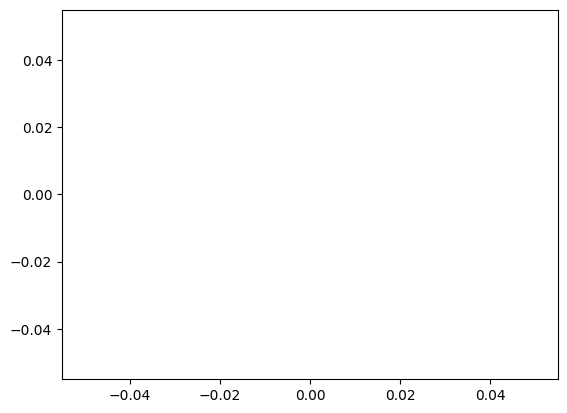

In [26]:
plt.plot(lri, lossi)

In [27]:
# loss over training set

emb = C[Xtr] # (60, 3, 2)
h = (emb.view(-1,128) @ W1 + b1).tanh() # (60, 100)
logits = h @ W2 + b2 # (60, 60)
#counts = logits.exp()
#prob = counts / counts.sum(1, keepdim=True) # normalizing
#loss = -prob[Tensor.arange(60), Y].log().mean()
loss = Tensor.cross_entropy(logits, Ytr)
loss.realize()
print(f'empirical loss: {loss.item()}')

empirical loss: 3.634434938430786


In [28]:
# loss over dev test

emb = C[Xdev] # (60, 3, 2)
h = (emb.view(-1,128) @ W1 + b1).tanh() # (60, 100)
logits = h @ W2 + b2 # (60, 60)
#counts = logits.exp()
#prob = counts / counts.sum(1, keepdim=True) # normalizing
#loss = -prob[Tensor.arange(60), Y].log().mean()
loss = Tensor.cross_entropy(logits, Ydev)
print(f'empirical loss: {loss.item()}')

empirical loss: 6.283635139465332


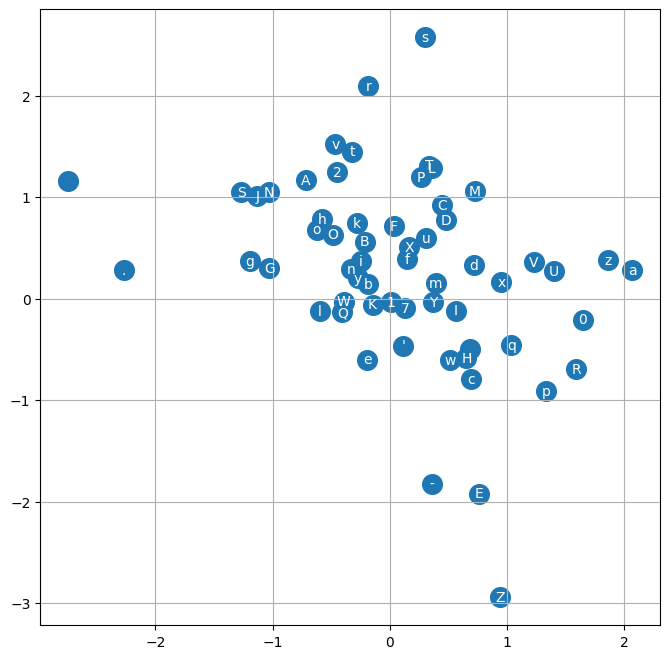

In [29]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data(), C[:,1].data(), s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color="white")
plt.grid('minor')

In [30]:
# training split, dev/validation split, test split
# 80%, 10%, 10% of data set

In [31]:
# sample from the model

for _ in range(10):
    out = []
    context = [0] * block_size # initialize with all ... starting chars
    while True:
        emb = C[Tensor(context)] # (1, block_size, d)
        h = (emb.view(1, -1) @ W1 + b1).tanh()
        logits = h @ W2 + b2
        probs = logits.softmax(axis=1)
        ix = probs.multinomial(num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

Ice 'andefBrusY.
Bouding.
IAizht.
Pr Pon Spore Comelsiioelearing tinr.
Crunp.
Maliof.
Dngy H Beee.
Setrn QhNGT2C.
Slult.
Aralter.
